In [1]:
import os
import sys
from datetime import datetime
import keras

import argparse
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Adamax
import keras.backend as K

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from func import * 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='multi', help='prediction target')
parser.add_argument('-cv_path' ,'--cv_path', type=str, default='/home/katieyth/gynecology/data/5_fold_CMU_rs_13/', help='cv_path')

 
# input parameter
parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
parser.add_argument('-ks','--k_slice', type=int, default=1, help='a input will be sliced into k_slice segments when testing')
parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')

# data augmentation 
parser.add_argument('-aug_fliplr' ,'--aug_fliplr', type=int, default=0, help='reverse time series')
parser.add_argument('-shift' ,'--DA_Shift', type=int, default=1, help='')
parser.add_argument('-scale' ,'--DA_Scale', type=int, default=1, help='')
parser.add_argument('-randsamp' ,'--DA_RandSampling', type=int, default=1, help='')


# model parameters
parser.add_argument('-struc' ,'--struc', type=str, default='multi_task_FHB', help='deeper or shallower')
parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
parser.add_argument('-ly' ,'--layers', type=int, default=5, help='number of residual layers')
parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
parser.add_argument('-l2','--l2', type=float, default=0.01, help='coefficient of l2 regularization')

# hyper-parameters
parser.add_argument('-lr','--learning_rate', type=float, default=1e-4, help='learning_rate')
parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=50, help='reduce_lr_patience')
parser.add_argument('-bs','--batch_size', type=int, default=27, help='batch_size')
parser.add_argument('-ep','--epoch', type=int, default=15, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=1, help='whether weight balancing or not')
parser.add_argument('-mntr','--monitor', type=str, default='val_man_acc', help='val_acc or val_loss')

parser.add_argument('-g' ,'--gpu_id', type=str, default='6', help='GPU ID')
parser.add_argument('-fd' ,'--fold', type=int, default=1, help='CMU_5_fold')
parser.add_argument('-fn' ,'--summary_file', type=str, default='', help='summary filename')

FLAG = parser.parse_args([])
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id

In [3]:
def data_preprocess_test(Xvalid, Yvalid, length=600):
    Xtest = np.empty((Xvalid.shape[0], length, Xvalid.shape[2]))
    for i in range(Xvalid.shape[0]):
        Xtest[i,:,:] = data_normalize(Xvalid[i,0:600,:])
    Ytest = Yvalid.copy()
    return Xtest, Ytest

In [5]:
### data preparing
train_d = pd.read_csv(os.path.join(FLAG.cv_path, '5_fold_0%s_train.csv' %(FLAG.fold)))
valid_d = pd.read_csv(os.path.join(FLAG.cv_path, '5_fold_0%s_test.csv' %(FLAG.fold)))

# replace 0 (no readings) with np.nan for later substitution
for k in train_d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        train_d.loc[train_d[k]==0, k] = np.nan
for k in valid_d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        valid_d.loc[valid_d[k]==0, k] = np.nan

    
# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
target_list = ['management', 'UA', 'variability', 'deceleration', 'FHB_class']
target_dict = {'management':3,
               'UA':2,
               'variability':2,
               'deceleration':4,
               'FHB_class':4}
Ytrain = [(keras.utils.to_categorical(np.array(train_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]
Yvalid = [(keras.utils.to_categorical(np.array(valid_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]

#weight balancing or not
if FLAG.weight_balance:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        y_integers = np.argmax(Ytrain[idx], axis=1)
        d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
        class_weight = dict(enumerate(d_class_weight))
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)
else:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        class_weight = dict()
        for i in range(target_dict[c_name]):
            class_weight[i] = 1
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)

Xtest, Ytest =data_preprocess_test(Xvalid, Yvalid)


if FLAG.aug_fliplr:
    Xtrain_copy = Xtrain.copy()
    for i in range(len(Xtrain)):
        Xtrain_copy[i] = np.fliplr([Xtrain[i]])[0]
        print(i,'/',len(Xtrain), end= '\r')
    Xtrain = np.vstack((Xtrain, Xtrain_copy))
    Ytrain = np.vstack((Ytrain, Ytrain))

print('train:', len(train_d))
print('test:', len(valid_d))

class weight: {0: 0.5142857142857142, 1: 1.0384615384615385, 2: 10.8}
class weight: {0: 5.4, 1: 0.5510204081632653}
class weight: {0: 0.5664335664335665, 1: 4.2631578947368425}
class weight: {0: 0.4308510638297872, 1: 1.9285714285714286, 2: 0.9, 3: 20.25}
class weight: {0: 0.50625, 1: 40.5}
train: 162
test: 45


# model

In [6]:
if FLAG.struc =='deeper':
    from model_multitask_more import build_model
elif FLAG.struc =='shallower':
    from model_multitask import build_model
elif FLAG.struc =='man_concat':
    from model_multitask_more_concat import build_model
elif FLAG.struc =='man_concat_shallower':
    from model_multitask_more_concat_shallower import build_model
elif FLAG.struc =='mimic_previous':
    from model_multitask_more_concat_mimic_previous import build_model
elif FLAG.struc =='mimic_previous_FHB':
    from model_multitask_more_concat_mimic_previous_FHB import build_model
elif FLAG.struc =='multi_task_FHB':
    from model_multitask_more_FHB import build_model

In [7]:
augtool = (DA_Shift,DA_Scale,DA_RandSampling)
choose_augtool = (FLAG.DA_Shift,FLAG.DA_Scale,FLAG.DA_RandSampling)
augset = [x for x, y in zip(augtool, choose_augtool) if y == 1]
augset

[<function func.DA_Shift>,
 <function func.DA_Scale>,
 <function func.DA_RandSampling>]

In [8]:
def my_generator(Xtrain, Ytrain, tg_list, tg_dict,
                 length=300, n_channel=2,  batch_size=16, prob=0.5,
                 aug_func=[], random_noise = False, normalized = True):
    n_sample = Xtrain.shape[0]
    n_length = Xtrain.shape[1]
    ind = list(range(n_sample))
    x = np.empty((batch_size, length, n_channel), dtype=np.float)
    
    y_list = [(np.empty((batch_size, tg_dict[c_name]), dtype=int)) for c_name in tg_list]

    while True:
        np.random.shuffle(ind)
        for i in range(n_sample//batch_size):
            if length==600:
                st = 0
            else:
                st = random.choice(np.arange(0, Xtrain.shape[1] - length))
            i_batch = ind[i*batch_size:(i+1)*batch_size]
            for j, k in enumerate(i_batch):
                x[j,:] = data_preprocess(Xtrain[k,st:(st+length),:], aug_func=aug_func, prob=prob, random_noise=random_noise, normalized=normalized)
                for c_idx in range(len(tg_list)):
                    y_list[c_idx][j,:] = Ytrain[c_idx][k,:] 
                
            yield x, y_list

In [9]:
train_gen = my_generator(Xtrain, Ytrain, 
                         tg_list = target_list,
                         tg_dict = target_dict,
                        length=FLAG.length, 
                        n_channel=FLAG.n_channel, 
                        random_noise=FLAG.random_noise,
                        normalized=FLAG.normalized,
                        batch_size=FLAG.batch_size,
                        aug_func=augset,
                        prob=0.25)

In [10]:
# Get a "l2 norm of gradients" tensor
def get_gradient_norm(model):
    with K.name_scope('gradient_norm'):
        grads = K.gradients(model.total_loss, model.trainable_weights)
        norm = K.sqrt(sum([K.sum(K.square(g)) for g in grads]))
    return norm

In [11]:
# import numpy as np
# from keras.callbacks import Callback
# from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
# class Metrics(Callback):
# #     def on_train_begin(self, logs={}):

#     def __init__(self):
#         self.val_f1s = []
#         self.val_recalls = []
#         self.val_precisions = []
#     def get_data(self, Xtest, Ytest, logs={}):
#         self.X = Xtest
#         self.Y = Ytest
#         self.c_dict = {'management':0,
#                        'UA':1,
#                        'variability':2,
#                        'deceleration':3,
#                        'FHB':4,
#                        'management_concat':5}
#         self.target = 'management'
#     def on_epoch_end(self, epoch, logs={}):
#         Pred = self.model.predict(self.X)
#         val_predict = np.argmax(Pred[self.c_dict[self.target]] , axis=1)
#         val_targ = np.argmax(Ytest[self.c_dict[self.target]], axis=1)
#         _val_f1 = f1_score(val_targ, val_predict, average=None)
#         _val_recall = recall_score(val_targ, val_predict, average=None)
#         _val_precision = precision_score(val_targ, val_predict, average=None)
        
# #         print("************%f *********** %f" %((sum(_val_f1)/len(_val_f1)), max(self.val_f1s)))
#         if (sum(_val_f1)/len(_val_f1))> max(self.val_f1s):
#             print('HEEEEEEEEEEEELLLLLLLLLLLLLLLLLLLLLLLLLLO')
#         print(val_f1s)
        
#         self.val_f1s.append(sum(_val_f1)/len(_val_f1))
#         self.val_recalls.append(sum(_val_recall)/len(_val_recall))
#         self.val_precisions.append(sum(_val_precision)/len(_val_precision))
#         print(val_f1s)
#         print(" — val_f1: %f — val_recall: %f — val_precision %f" %(sum(_val_f1)/len(_val_f1),
#                                                                     sum(_val_recall)/len(_val_recall),
#                                                                     sum(_val_precision)/len(_val_precision)))
# m = Metrics()
# m.get_data(Xtest,Ytest)

In [12]:
print("===== create directory =====")
model_id = FLAG.target + "_" + datetime.now().strftime("%y%m%d%H%M%S")
model_save = os.path.join(FLAG.model_save, FLAG.target, model_id)
summary_save = os.path.join(FLAG.model_save, FLAG.target, 'summary_'+FLAG.target+'_'+FLAG.summary_file+'.csv')

if not os.path.exists(model_save):
    os.makedirs(model_save)
    print(model_save)

# declare model and compile it 
model = build_model(length=FLAG.length, n_channel=FLAG.n_channel,  filters=FLAG.filters,
                    kernel_size=FLAG.kernel_size, layers=FLAG.layers,
                activation=FLAG.activation, kernel_initializer=FLAG.kernel_initializer, l_2=FLAG.l2)
model.summary()
lr_rate = FLAG.learning_rate
adam = Adamax(lr_rate, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay = 0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# 還沒有 compile 前拿不到 total loss 這個 tensor, 也拿不到 metrics 這個東西
# Append the "l2 norm of gradients" tensor as a metric
model.metrics_names.append("gradient_norm")
model.metrics_tensors.append(get_gradient_norm(model))


csv_logger = CSVLogger(os.path.join(model_save, 'training.log'), append = True)
checkpoint = ModelCheckpoint(os.path.join(model_save, 'model.h5'), 
                                            monitor=FLAG.monitor, 
                                            verbose=1, 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='auto',
                                            period=1)
earlystop = EarlyStopping(monitor = FLAG.monitor, patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor=FLAG.monitor, factor = 0.5, patience = FLAG.reduce_lr_patience, min_lr = 0, cooldown = 5, verbose = True)

===== create directory =====
/home/katieyth/gynecology/model_save/multi/multi_190119171355
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 600, 64)      448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 600, 64)      256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 600, 64)      0           batch_normalization_1[0][0]      
__________________

In [13]:
model.fit_generator(generator=train_gen,
                    class_weight={'man': weight_list[0],
                                  'ua' : weight_list[1],
                                  'var': weight_list[2],
                                  'dec': weight_list[3],
                                  'fhb': weight_list[4]},
                    validation_data=(Xtest, {'man':Ytest[0],
                                             'ua' :Ytest[1],
                                             'var':Ytest[2],
                                             'dec':Ytest[3],
                                             'fhb':Ytest[4]}),
                    steps_per_epoch=50, 
                    epochs=FLAG.epoch,
                    verbose=1,
                    callbacks=[csv_logger,
                               reduce_lr, 
                               checkpoint,
                               earlystop
                              ])

Epoch 1/15
49/50 [============================>.] - ETA: 0s - loss: 28.3221 - man_loss: 1.1058 - ua_loss: 0.7179 - var_loss: 0.6932 - dec_loss: 1.8223 - fhb_loss: 1.5717 - man_acc: 0.4807 - ua_acc: 0.8095 - var_acc: 0.6440 - dec_acc: 0.5986 - fhb_acc: 0.0506 - gradient_norm: 56.8181
Epoch 00001: val_man_acc improved from -inf to 0.62222, saving model to /home/katieyth/gynecology/model_save/multi/multi_190119171355/model.h5
50/50 [==============================] - 19s 380ms/step - loss: 28.3161 - man_loss: 1.0997 - ua_loss: 0.7128 - var_loss: 0.6898 - dec_loss: 1.8111 - fhb_loss: 1.5922 - man_acc: 0.4852 - ua_acc: 0.8104 - var_acc: 0.6415 - dec_acc: 0.5978 - fhb_acc: 0.0533 - gradient_norm: 56.9533 - val_loss: 26.9920 - val_man_loss: 1.0634 - val_ua_loss: 0.4231 - val_var_loss: 0.4966 - val_dec_loss: 0.8676 - val_fhb_loss: 1.7615 - val_man_acc: 0.6222 - val_ua_acc: 0.8222 - val_var_acc: 0.6889 - val_dec_acc: 0.6889 - val_fhb_acc: 0.0889 - val_gradient_norm: 65.2522
Epoch 2/15
49/50 [===

Epoch 10/15
49/50 [============================>.] - ETA: 0s - loss: 24.9406 - man_loss: 0.7384 - ua_loss: 0.3767 - var_loss: 0.4796 - dec_loss: 0.8018 - fhb_loss: 0.6057 - man_acc: 0.6206 - ua_acc: 0.7400 - var_acc: 0.6924 - dec_acc: 0.7211 - fhb_acc: 0.7188 - gradient_norm: 23.4779 ETA: 2s - loss: 24.9236 - man_loss: 0.7611 - ua_loss: 0.4045 - var_loss: 0.4936 - dec_loss: 0.7669 - fhb_loss: 0.5377 - man_acc: 0.5778 - ua_acc: 0.7296 - var_
Epoch 00010: val_man_acc did not improve
50/50 [==============================] - 3s 67ms/step - loss: 24.9482 - man_loss: 0.7375 - ua_loss: 0.3780 - var_loss: 0.4832 - dec_loss: 0.8084 - fhb_loss: 0.6031 - man_acc: 0.6222 - ua_acc: 0.7407 - var_acc: 0.6926 - dec_acc: 0.7200 - fhb_acc: 0.7178 - gradient_norm: 23.6885 - val_loss: 25.2453 - val_man_loss: 0.8818 - val_ua_loss: 0.4762 - val_var_loss: 0.3518 - val_dec_loss: 0.6512 - val_fhb_loss: 0.9745 - val_man_acc: 0.6667 - val_ua_acc: 0.7556 - val_var_acc: 0.8667 - val_dec_acc: 0.7778 - val_fhb_acc: 

In [14]:
def plot_keras_csv_logger(csv_logger, save_dir='', accuracy=False, gradient=False):
    if type(csv_logger) is str:
        loss = pd.read_table(csv_logger, delimiter=',')
    else:
        loss = pd.read_table(csv_logger.filename, delimiter=',')
    print('min val_loss {0} at epoch {1}'.format(min(loss.val_loss), np.argmin(loss.val_loss)))
    plt.plot(loss.epoch, loss.loss, label='loss')
    plt.plot(loss.epoch, loss.val_loss, label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.show()
    plt.close()

    if accuracy:
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_dec_acc), np.argmax(loss.val_dec_acc)))
        plt.plot(loss.epoch, loss.dec_acc, label='dec_acc')
        plt.plot(loss.epoch, loss.val_dec_acc, label='val_dec_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'dec_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_var_acc), np.argmax(loss.val_var_acc)))
        plt.plot(loss.epoch, loss.var_acc, label='var_acc')
        plt.plot(loss.epoch, loss.val_var_acc, label='val_var_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'var_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_ua_acc), np.argmax(loss.val_ua_acc)))
        plt.plot(loss.epoch, loss.ua_acc, label='ua_acc')
        plt.plot(loss.epoch, loss.val_ua_acc, label='val_ua_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'ua_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_man_acc), np.argmax(loss.val_man_acc)))
        plt.plot(loss.epoch, loss.man_acc, label='man_acc')
        plt.plot(loss.epoch, loss.val_man_acc, label='val_man_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'man_acc.png'))
        plt.show()
        plt.close()
       
    if gradient:
        plt.plot(loss.epoch, loss.gradient_norm, label='gradient_norm')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('gradient_norm')
        plt.savefig(os.path.join(save_dir, 'gradient.png'))
        plt.show()
        plt.close()

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


min val_loss 24.519139099121087 at epoch 14


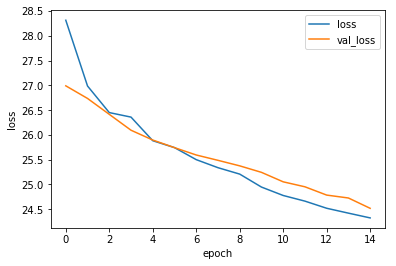

max val_accu 0.8 at epoch 8


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


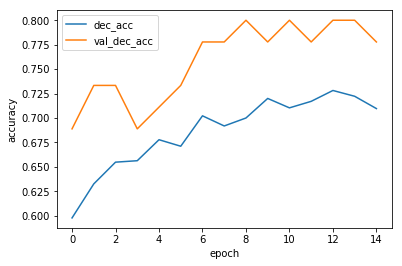

max val_accu 0.9111111044883728 at epoch 8


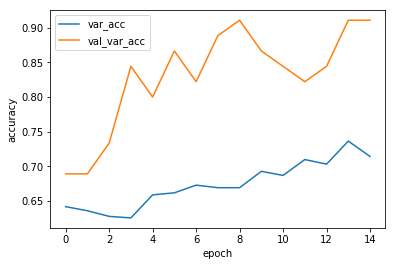

max val_accu 0.8222222089767456 at epoch 0


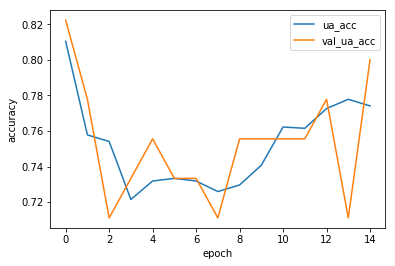

max val_accu 0.7111111044883728 at epoch 7


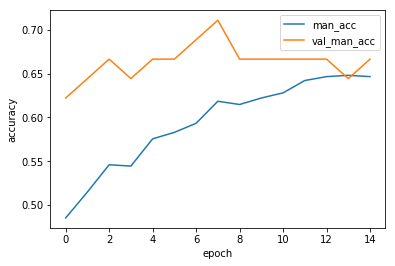

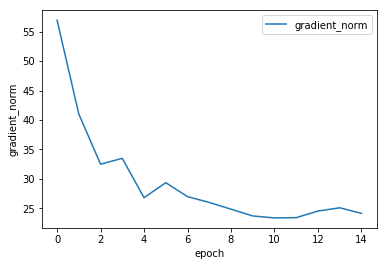

In [15]:
plot_keras_csv_logger(csv_logger, save_dir=model_save, accuracy=True, gradient = True)

# test saved model

In [16]:
path = model_save
print(path)
loss = pd.read_table(csv_logger.filename, delimiter=',')
best_val_loss = np.min(loss.val_loss)
best_epoch = np.argmin(loss.val_loss)


# model_id =  'multi_190114123245'
# path = os.path.join(FLAG.model_save,FLAG.target, model_id)
# loss = pd.read_table(os.path.join(path, 'training.log'), delimiter=',')
# best_val_loss = np.min(loss.val_loss)
# best_epoch = np.argmin(loss.val_loss)
# model_save = '.'


/home/katieyth/gynecology/model_save/multi/multi_190119171355


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [17]:
# evaluate validation set
trained_model = load_model(os.path.join(path,'model.h5'))
Pred = trained_model.predict(Xtest)


In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save_dir=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if not save_dir =='':
        plt.savefig(os.path.join(save_dir))

management accuracy :  0.7111111111111111
management_recall-0 : 0.8571
management_recall-1 : 0.4000
management_recall-2 : 1.0000
management_recall-average : 0.7524
management_precision-0: 0.8000
management_precision-1: 0.6000
management_precision-2: 0.4000
management_precision-average : 0.6000
management_F1-0: 0.8276
management_F1-1: 0.4800
management_F1-2: 0.5714
management_F1-average : 0.6263
Confusion matrix, without normalization
[[24  4  0]
 [ 6  6  3]
 [ 0  0  2]]
UA accuracy :  0.7111111111111111
UA_recall-0 : 0.8000
UA_recall-1 : 0.7000
UA_recall-average : 0.7500
UA_precision-0: 0.2500
UA_precision-1: 0.9655
UA_precision-average : 0.6078
UA_F1-0: 0.3810
UA_F1-1: 0.8116
UA_F1-average : 0.5963
Confusion matrix, without normalization
[[ 4  1]
 [12 28]]
variability accuracy :  0.8888888888888888
variability_recall-0 : 0.9250
variability_recall-1 : 0.6000
variability_recall-average : 0.7625
variability_precision-0: 0.9487
variability_precision-1: 0.5000
variability_precision-average

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


FHB accuracy :  0.6444444444444445
FHB_recall-0 : 0.6444
FHB_recall-1 : nan
FHB_recall-2 : nan
FHB_recall-3 : nan
FHB_recall-average : nan
FHB_precision-0: 1.0000
FHB_precision-1: 0.0000
FHB_precision-2: 0.0000
FHB_precision-3: 0.0000
FHB_precision-average : 0.2500
FHB_F1-0: 0.7838
FHB_F1-1: 0.0000
FHB_F1-2: 0.0000
FHB_F1-3: 0.0000
FHB_F1-average : 0.1959
Confusion matrix, without normalization
[[29 11  2  3]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]
management_2_recall-0 : 0.8571
management_2_recall-1 : 0.6471
management_2_recall-average : 0.7521
management_2_precision-0: 0.8000
management_2_precision-1: 0.7333
management_2_precision-average : 0.7667
management_2_F1-0: 0.8276
management_2_F1-1: 0.6875
management_2_F1-average : 0.7575
Confusion matrix, without normalization
[[24  4]
 [ 6 11]]


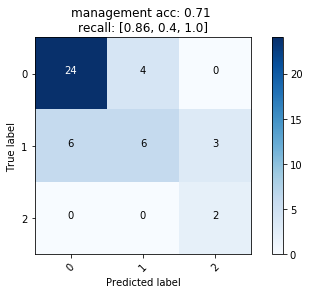

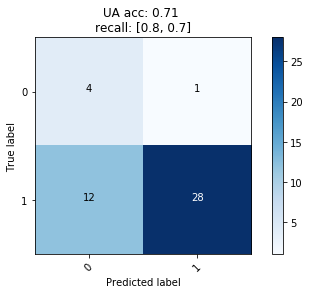

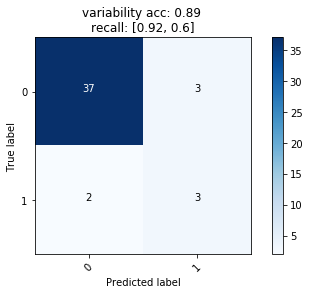

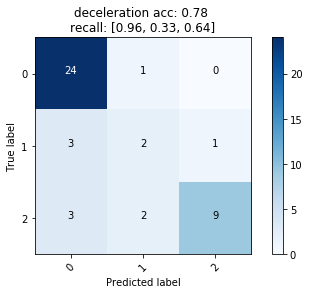

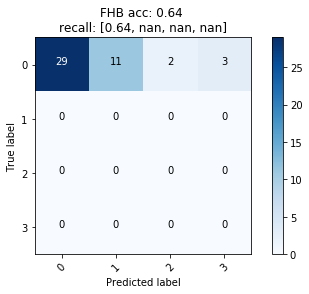

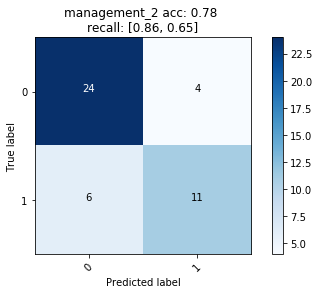

In [19]:
# save into dictionary
sav = vars(FLAG)
sav['epoch'] = best_epoch
sav['val_loss'] = best_val_loss
sav['model_id'] = model_id

c_list = ['management', 'UA', 'variability', 'deceleration', 'FHB']
for c in range(len(c_list)):
    ypred_aug = np.argmax(Pred[c] , axis=1)
    ytest_aug = np.argmax(Ytest[c], axis=1)

    cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
    f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
#         _val_recall = recall_score(val_targ, val_predict, average=None)
#         _val_precision = precision_score(val_targ, val_predict, average=None)
    
    

    print('%s accuracy : ' % (c_list[c]), val_accu)
    tmp_list = []
    for i in range(len(recall)):
        print('%s_recall-%d : %.4f' %(c_list[c],i, recall[i]))
        sav['%s_recall-%d' %(c_list[c], i)] = recall[i]
        tmp_list.append(recall[i])
    print('%s_recall-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_recall-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(precision)):
        print('%s_precision-%d: %.4f' % (c_list[c],i, precision[i]))
        sav['%s_precision-%d' %(c_list[c], i)] = precision[i]
        tmp_list.append(precision[i])
    print('%s_precision-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_precision-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(f1)):
        print('%s_F1-%d: %.4f' % (c_list[c],i, f1[i]))
        sav['%s_F1-%d' %(c_list[c], i)] = f1[i]
        tmp_list.append(f1[i])
    print('%s_F1-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_F1-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    sav['val_%s_acc' %(c_list[c])] = val_accu

    plt.figure()
    rcl = [round(recall[i],2) for i in range(len(recall))]
    plot_confusion_matrix(cfm, classes=np.arange(len(recall)),
                          title='%s acc: %.2f \nrecall: %s' %(c_list[c], val_accu,rcl),
                          save_dir=model_save+'/%s_cm.png' % (c_list[c]) )
# force management to 2 label 
c_list = ['management_2']
for idx, c in enumerate([0]):
    # evaluate by every segment
    ypred_aug = np.argmax(Pred[c] , axis=1)
    ytest_aug = np.argmax(Ytest[c], axis=1)
    ypred_aug[ypred_aug>1]=1
    ytest_aug[ytest_aug>1]=1

    cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
    f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
    
    tmp_list = []
    for i in range(len(recall)):
        print('%s_recall-%d : %.4f' %(c_list[idx],i, recall[i]))
        sav['%s_recall-%d' %(c_list[idx], i)] = recall[i]
        tmp_list.append(recall[i])
    print('%s_recall-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_recall-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(precision)):
        print('%s_precision-%d: %.4f' % (c_list[idx],i, precision[i]))
        sav['%s_precision-%d' %(c_list[idx], i)] = precision[i]
        tmp_list.append(precision[i])
    print('%s_precision-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_precision-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(f1)):
        print('%s_F1-%d: %.4f' % (c_list[idx],i, f1[i]))
        sav['%s_F1-%d' %(c_list[idx], i)] = f1[i]
        tmp_list.append(f1[i])
    print('%s_F1-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_F1-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    sav['val_%s_acc' %(c_list[idx])] = val_accu

    plt.figure()
    rcl = [round(recall[i],2) for i in range(len(recall))]
    plot_confusion_matrix(cfm, classes=np.arange(len(recall)), 
                          title='%s acc: %.2f \nrecall: %s' %(c_list[idx], val_accu,rcl),
                          save_dir=model_save+'/%s_cm.png' % (c_list[idx]) )


In [20]:
# append into summary files
dnew = pd.DataFrame(sav, index=[0])
if os.path.exists(summary_save):
    dori = pd.read_csv(summary_save)
    dori = pd.concat([dori, dnew])
    dori.to_csv(summary_save, index=False)
else:
    dnew.to_csv(summary_save, index=False)

print(summary_save)



/home/katieyth/gynecology/model_save/multi/summary_multi_.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """
